# Reinforcement-Based Clustering with Nested While Loops

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [32]:
# Hyperparameters
beta_min = 0.01
beta_max = 300.0
tau = 1.5
M = 2  # number of clusters
H = 10  # update target model every H steps
S = 1000  # replay buffer size
batch_size = 32
input_dim = 2
hidden_dim = 32
learning_rate = 0.001
alpha = 0.05  # step size for cluster center update

# Dummy data
X = torch.randn(300, input_dim)
Y = torch.randn(M, input_dim)  # cluster centers

# Replay buffer
replay_buffer = deque(maxlen=S)

# Loss tracker
loss_history = []

In [33]:
class DistanceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x_i, y_j):
        return self.model(torch.cat([x_i, y_j], dim=1))

In [34]:
model = DistanceModel()
target_model = DistanceModel()
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
def compute_policy(x_i, beta):
    with torch.no_grad():
        distances = torch.stack([target_model(x_i, Y[j].unsqueeze(0)) for j in range(M)]).squeeze()
        probs = torch.softmax(-beta * distances, dim=0)
    return probs

In [36]:
beta = beta_min
step = 0

while beta <= beta_max:
    print(f"\nStarting beta = {beta:.2f}")
    
    # First inner loop: update θ
    inner_converged = False
    inner_steps = 0
    while not inner_converged:
        i = random.randint(0, len(X) - 1)
        x_i = X[i].unsqueeze(0)
        pi = compute_policy(x_i, beta)
        j = torch.multinomial(pi, 1).item()
        y_j = Y[j].unsqueeze(0)
        d = torch.norm(x_i - y_j).item()

        replay_buffer.append((i, j, d, j))  # k = j

        if len(replay_buffer) < batch_size:
            continue

        minibatch = random.sample(replay_buffer, batch_size)
        loss = 0
        for (i_b, j_b, d_b, _) in minibatch:
            x_b = X[i_b].unsqueeze(0)
            y_b = Y[j_b].unsqueeze(0)
            pred = model(x_b, y_b).squeeze()
            loss += (d_b - pred)**2

        loss /= batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        step += 1
        inner_steps += 1

        if step % H == 0:
            target_model.load_state_dict(model.state_dict())

        if inner_steps > 300:
            inner_converged = True

    # Second inner loop: update Y
    outer_converged = False
    outer_steps = 0
    while not outer_converged:
        for l in range(M):
            if len(replay_buffer) < batch_size:
                continue
            minibatch = random.sample(replay_buffer, batch_size)
            for (i_b, j_b, d_b, _) in minibatch:
                x_b = X[i_b]
                pi = compute_policy(x_b.unsqueeze(0), beta)
                for k in range(M):
                    delta = 1.0 if k == j_b else 0.0
                    Y[k] = Y[k] - alpha * pi[k].item() * (Y[k] - x_b) * delta
        outer_steps += 1
        if outer_steps > 10:
            outer_converged = True

    beta *= tau


Starting beta = 0.01

Starting beta = 0.01

Starting beta = 0.02

Starting beta = 0.03

Starting beta = 0.05

Starting beta = 0.08

Starting beta = 0.11

Starting beta = 0.17

Starting beta = 0.26

Starting beta = 0.38

Starting beta = 0.58

Starting beta = 0.86

Starting beta = 1.30

Starting beta = 1.95

Starting beta = 2.92

Starting beta = 4.38

Starting beta = 6.57

Starting beta = 9.85

Starting beta = 14.78

Starting beta = 22.17

Starting beta = 33.25

Starting beta = 49.88

Starting beta = 74.82

Starting beta = 112.23

Starting beta = 168.34

Starting beta = 252.51


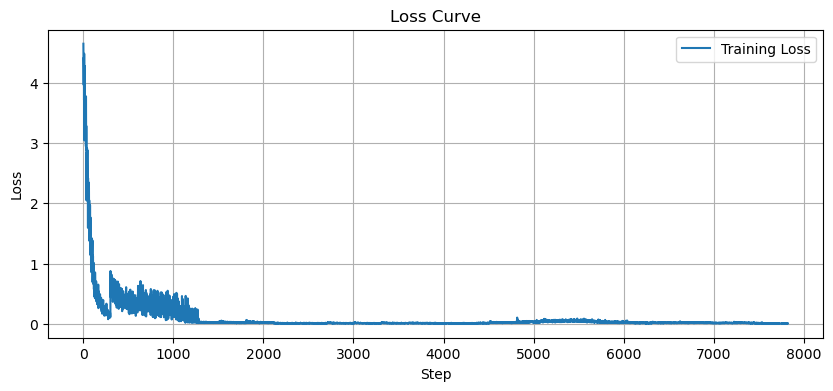

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

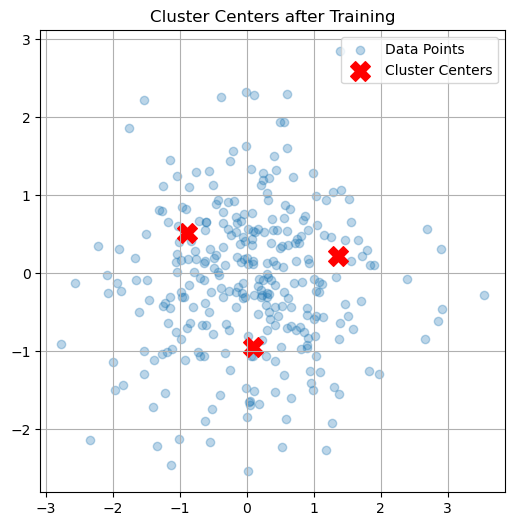

In [28]:
X_np = X.detach().numpy()
Y_np = Y.detach().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], alpha=0.3, label="Data Points")
plt.scatter(Y_np[:, 0], Y_np[:, 1], c="red", marker="X", s=200, label="Cluster Centers")
plt.title("Cluster Centers after Training")
plt.legend()
plt.grid(True)
plt.show()

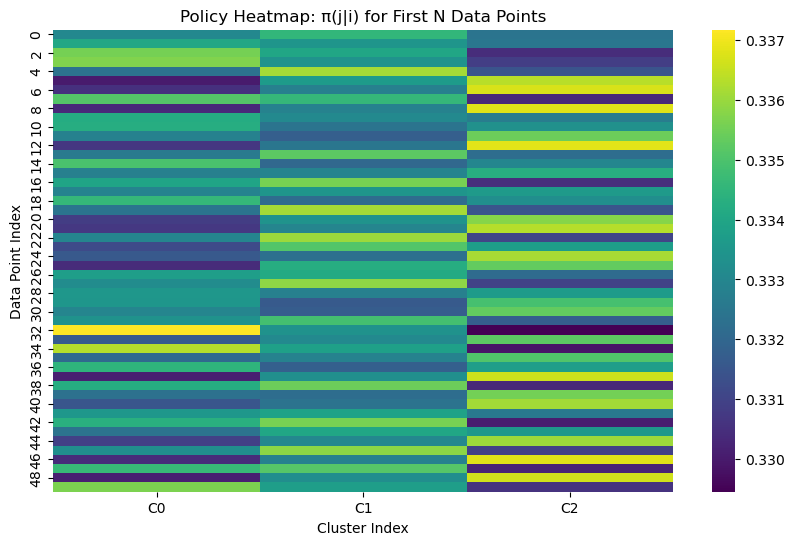

In [29]:
# Number of data points to visualize
N = 50  # Adjust as needed

policy_matrix = np.zeros((N, M))
for idx in range(N):
    x_i = X[idx].unsqueeze(0)
    probs = compute_policy(x_i, beta_min).detach().numpy()
    policy_matrix[idx, :] = probs

plt.figure(figsize=(10, 6))
sns.heatmap(policy_matrix, annot=False, cmap="viridis", xticklabels=[f"C{k}" for k in range(M)])
plt.xlabel("Cluster Index")
plt.ylabel("Data Point Index")
plt.title("Policy Heatmap: π(j|i) for First N Data Points")
plt.show()

In [30]:
policy_matrix

array([[0.33304411, 0.33453807, 0.33241776],
       [0.33403927, 0.33347023, 0.33249044],
       [0.33554673, 0.33401215, 0.33044109],
       [0.33571294, 0.33342826, 0.33085883],
       [0.33239135, 0.33613807, 0.33147058],
       [0.32999787, 0.33365697, 0.33634517],
       [0.33051762, 0.3327702 , 0.33671215],
       [0.33511367, 0.33458433, 0.33030197],
       [0.33034295, 0.33285519, 0.33680186],
       [0.33420742, 0.33309892, 0.33269373],
       [0.3342604 , 0.33241022, 0.33332935],
       [0.33281958, 0.33174786, 0.33543262],
       [0.33067465, 0.33249068, 0.33683467],
       [0.33260295, 0.3352223 , 0.33217475],
       [0.33495489, 0.33203563, 0.33300951],
       [0.33279201, 0.33292735, 0.3342807 ],
       [0.33395058, 0.3355943 , 0.33045506],
       [0.3328999 , 0.3334662 , 0.3336339 ],
       [0.33459523, 0.33215228, 0.33325252],
       [0.33241647, 0.33612698, 0.3314566 ],
       [0.33082449, 0.33341298, 0.33576253],
       [0.33071536, 0.33295417, 0.33633041],
       [0.

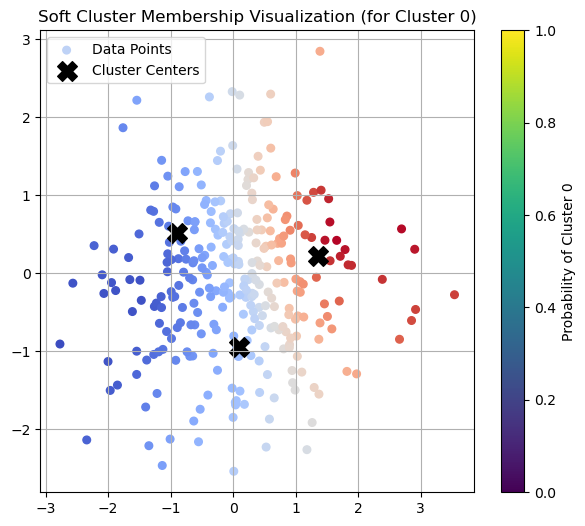

In [31]:
# Plot soft memberships for cluster 0
colors = []
for x in X:
    probs = compute_policy(x.unsqueeze(0), beta_min)
    colors.append(probs[0].item())  # probability of cluster 0

colors = np.array(colors)
X_np = X.detach().numpy()
Y_np = Y.detach().numpy()

plt.figure(figsize=(7, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=colors, cmap="coolwarm", s=30, label="Data Points")
plt.scatter(Y_np[:, 0], Y_np[:, 1], c="black", s=200, marker="X", label="Cluster Centers")
plt.colorbar(label="Probability of Cluster 0")
plt.title("Soft Cluster Membership Visualization (for Cluster 0)")
plt.legend()
plt.grid(True)
plt.show()